# Art &The New York Times

In [1]:
import math
import pickle
from datetime import datetime

import blaze
import matplotlib
import pandas as pd
from dateutil.relativedelta import relativedelta
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from pymongo import MongoClient

In [2]:
%matplotlib inline

In [3]:
matplotlib.rcParams['figure.max_open_warning'] = 300

In [4]:
import seaborn as sns

In [5]:
import numpy

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError ("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=numpy.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len/2-1):-(window_len/2)]


In [6]:
with open('sentiment/pipeline_nc.pickle', 'rb') as be_file:
    be = pickle.load(be_file)

In [7]:
be.predict(['My puppy is cute.', 'People die in war.', 'I love my family.'])

array(['pos', 'neg', 'pos'], dtype=object)

In [8]:
# 8 csv files previously built on another machine. Sentiment included.
data_blaze = blaze.Data('../nytimes/nyt_data/data_*.csv', delimiter=',')

In [9]:
# sentiment_data_ind = blaze.odo(data_blaze, pd.DataFrame)
# sentiment_data = sentiment_data_ind.drop('Unnamed: 0', axis=1) #comentar esta linea
sentiment_data = blaze.odo(data_blaze, pd.DataFrame)

In [10]:
# Delete startup
sentiment_data = sentiment_data[sentiment_data.term != 'startup']

In [11]:
# Total number of articles
sentiment_data.article_id.value_counts().count()

529903

In [12]:
# Total number of terms
sentiment_data.term.value_counts().count()

214

In [13]:
# Total number of sentences
sentiment_data.sentence.value_counts().count()

845184

In [14]:
# sentiments_df = blaze.odo(data_blaze.sentence.map(lambda x: be.predict([x])[0], '?string'), pd.DataFrame)

## Art

In [73]:
import nltk
from nltk.stem.lancaster import LancasterStemmer

In [97]:
lancaster_stemmer = LancasterStemmer()

def stemmer(word):
    return lancaster_stemmer.stem(word)

In [98]:
def contains_art(sentence):
    tokens = nltk.word_tokenize(sentence)
    stems = map(stemmer, tokens)
    return any(map(lambda x: x == 'art', stems))

In [90]:
sentiment_data.head()

,article_id,pub_date,section_name,web_url,term_category,term,sentence,sentiment
0,4fd20d7d8eb7c8105d77daf9,1999-01-16,Sports,http://www.nytimes.com/1999/01/16/sports/plus-...,12,new venture,Keeneland's new venture came as a surprise to ...,pos
1,4fd20db88eb7c8105d77e511,1999-01-03,Arts; Books,http://www.nytimes.com/1999/01/03/books/heartb...,11,manager,The plan Presley and his hucksterish business ...,neg
2,5482d92a38f0d8403d9cd045,2008-07-08,Science,http://www.nytimes.com/2008/07/08/science/08an...,2,Twitch,In the male toadfish the swimbladder has been ...,pos
3,5456ab1438f0d86ef22a094e,2009-10-04,Real Estate,http://www.nytimes.com/2009/10/04/realestate/c...,11,executive,Mr. Pozycki is the chief executive of SJP Prop...,pos
4,5456ab1438f0d86ef22a094e,2009-10-04,Real Estate,http://www.nytimes.com/2009/10/04/realestate/c...,11,executive,Mr. Pozycki 59 is the chief executive of SJP P...,pos


In [99]:
art_data = sentiment_data[sentiment_data.sentence.apply(contains_art) == True]

In [100]:
len(art_data)

14282

In [122]:
len(sentiment_data)

933344

In [102]:
# Unique number of art sentences
art_data.sentence.value_counts().count()

12582

In [105]:
# % of art sentences: ~ 1.5%
art_data.sentence.value_counts().count() * 100 / sentiment_data.sentence.value_counts().count()

1.4886699227623807

In [15]:
# def split_dataframe(df, n):
#     d = {}
#     length = len(df)
#     chunk_size = math.ceil(length / n)
#     n_max = math.ceil(length / chunk_size)
#     for i in range(min(n, n_max)):
#         d[i] = df[chunk_size * i: chunk_size * (i + 1)]
#     return d

In [17]:
# def analyze_sentiment(df, i):
#     df['sentiment'] = df.sentence.map(lambda x: be.predict([x])[0])
#     df.to_csv('../nytimes/data_{}.csv'.format(i))
#     print('DataFrame saved in data_{}.csv'.format(i))

In [18]:
# N = 8
# data_dict = split_dataframe(data, N)
# # for i in range(N):
# #     analyze_sentiment(data_dict[i], i)
# Parallel(n_jobs=8)(delayed(analyze_sentiment)(data_dict[i], i) for i in range(N))

In [106]:
def diff_month(d1, d2):
    return (d2.year - d1.year) * 12 + d2.month - d1.month

# assert diff_month(datetime(2010,9,1), datetime(2010,10,1)) == 1
# assert diff_month(datetime(2009,10,1), datetime(2010,10,1)) == 12
# assert diff_month(datetime(2009,11,1), datetime(2010,10,1)) == 11
# assert diff_month(datetime(2009,8,1), datetime(2010,10,1)) == 14

In [108]:
art_data['n_month'] = art_data.pub_date.apply(lambda x: diff_month(datetime(1999, 1, 1), x.date()))

/home/antonio/.virtualenvs/nytimes/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [109]:
data2 = blaze.Data(art_data)

In [110]:
blaze.by(data2.term_category,
   total_amount=data2.sentiment.count(),
   amount_pos=data2[data2.sentiment == 'pos'].sentiment.count(),
   amount_neg=data2[data2.sentiment == 'neg'].sentiment.count()
)

,term_category,amount_neg,amount_pos,total_amount
0,2,747,2999,3746
1,3,150,439,589
2,11,1954,4775,6729
3,12,283,2935,3218


In [111]:
# Old classifier --> more positive

# blaze.by(data2.term_category,
#    total_amount=data2.sentiment.count(),
#    amount_pos=data2[data2.sentiment == 'pos'].sentiment.count(),
#    amount_neg=data2[data2.sentiment == 'neg'].sentiment.count()
# )

#  	term_category 	amount_neg 	amount_pos 	total_amount
# 0 	2 	106075 	251088 	357163
# 1 	3 	18546 	62625 	81171
# 2 	11 	206396 	200361 	406757
# 3 	12 	9900 	79663 	89563

## Visualizations

In [112]:
grouped_by_category = blaze.by(blaze.merge(data2.term_category, data2.n_month),
    total_amount=data2.sentiment.count(),
    amount_pos=data2[data2.sentiment == 'pos'].sentiment.count(),
    amount_neg=data2[data2.sentiment == 'neg'].sentiment.count(),
)

grouped_by_term = blaze.by(blaze.merge(data2.term, data2.n_month),
   total_amount=data2.sentiment.count(),
   amount_pos=data2[data2.sentiment == 'pos'].sentiment.count(),
   amount_neg=data2[data2.sentiment == 'neg'].sentiment.count()
)

In [113]:
grouped_by_category

,term_category,n_month,amount_neg,amount_pos,total_amount
0,2,0,6,12,18
1,2,1,1,12,13
2,2,2,5,13,18
3,2,3,2,7,9
4,2,4,1,18,19
5,2,5,6,14,20
6,2,6,2,13,15
7,2,7,8,11,19
8,2,8,7,19,26
9,2,9,4,25,29


In [118]:
def calc_xlim(start_from, df):
    return (max(datetime.strptime(start_from, "%Y-%m-%d"), df.index[0]), df.index[-1]) if start_from else None

def plot(term_list=None, same=False, info='total', category_list=None, figsize=(16, 8), window_len=20, window='hanning',
         start_from=None):
    if term_list and not same:
        for term in term_list:
            df = blaze.odo(grouped_by_term[grouped_by_term.original_term == term], pd.DataFrame)
            df.set_index('n_month', inplace=True)
            df.index = [datetime.strptime("1999-01-01", "%Y-%m-%d") + relativedelta(months=i) for i in df.index]
            df['pos_rate'] = df['amount_pos'] / df['total_amount']
            y1_df = df[['total_amount', 'amount_pos', 'amount_neg']]
            y1_df.plot(title=term, figsize=figsize, xlim=calc_xlim(start_from, y1_df))
            y2 = smooth(
                    df['pos_rate'].values,
                    window_len=window_len,
                    window=window
            )
            y2_df = pd.DataFrame(y2, columns=['pos_rate'], index=df.index)
            y2_df.plot(title=term, ylim=[0, 1], color='green', figsize=figsize, xlim=calc_xlim(start_from, y2_df))
    elif term_list and same:
        ax = plt.figure(figsize=figsize).add_subplot(1, 1, 1)
        for term in term_list:
            df = blaze.odo(grouped_by_term[grouped_by_term.original_term == term], pd.DataFrame)
            df.set_index('n_month', inplace=True)
            df.index = [datetime.strptime("1999-01-01", "%Y-%m-%d") + relativedelta(months=i) for i in df.index]
            df['pos_rate'] = df['amount_pos'] / df['total_amount']
            if info == 'total':
                y = smooth(
                    df['total_amount'].values,
                    window_len=window_len,
                    window=window
                )
                y_df = pd.DataFrame(y, columns=['total_amount'], index=df.index)
                y_df.plot(title='All together', figsize=figsize, ax=ax, xlim=calc_xlim(start_from, y_df))
            else:
                y = smooth(
                    df['pos_rate'].values,
                    window_len=window_len,
                    window=window
                )
                y_df = pd.DataFrame(y, columns=['pos_rate'], index=df.index)
                y_df.plot(title='All together', ylim=[0, 1], figsize=figsize, ax=ax, xlim=calc_xlim(start_from, y_df))
        ax.legend(term_list)
    elif category_list:
        category_dict = {
            11: 'executive/manager',
            12: 'entrepreneur/founder/new venture',
            2: 'big companies',
            3: 'new companies',
        }
        if not same:
            for category in category_list:
                df = blaze.odo(grouped_by_category[grouped_by_category.term_category == category], pd.DataFrame)
                df.set_index('n_month', inplace=True)
                df.index = [datetime.strptime("1999-01-01", "%Y-%m-%d") + relativedelta(months=i) for i in df.index]
                df['pos_rate'] = df['amount_pos'] / df['total_amount']
                y1_df = df[['total_amount', 'amount_pos', 'amount_neg']]
                y1_df.plot(title=category_dict[category], figsize=figsize, xlim=calc_xlim(start_from, y1_df))
        else:
            ax = plt.figure(figsize=figsize).add_subplot(1, 1, 1)
            for category in category_list:
                df = blaze.odo(grouped_by_category[grouped_by_category.term_category == category], pd.DataFrame)
                df.set_index('n_month', inplace=True)
                df.index = [datetime.strptime("1999-01-01", "%Y-%m-%d") + relativedelta(months=i) for i in df.index]
                df['pos_rate'] = df['amount_pos'] / df['total_amount']
                y2 = smooth(
                        df['pos_rate'].values,
                        window_len=window_len,
                        window=window
                )
                y2_df = pd.DataFrame(y2, columns=['pos_rate'], index=df.index)
                y2_df.plot(title='All together', ylim=[0, 1], figsize=figsize, ax=ax, xlim=calc_xlim(start_from, y2_df))
            ax.legend(['new companies', 'big companies', 'entrepreneur/founder', 'executive/manager'])

### Categories

## Fig.1 Distribution of sentences by category over the period 1999 to 2014

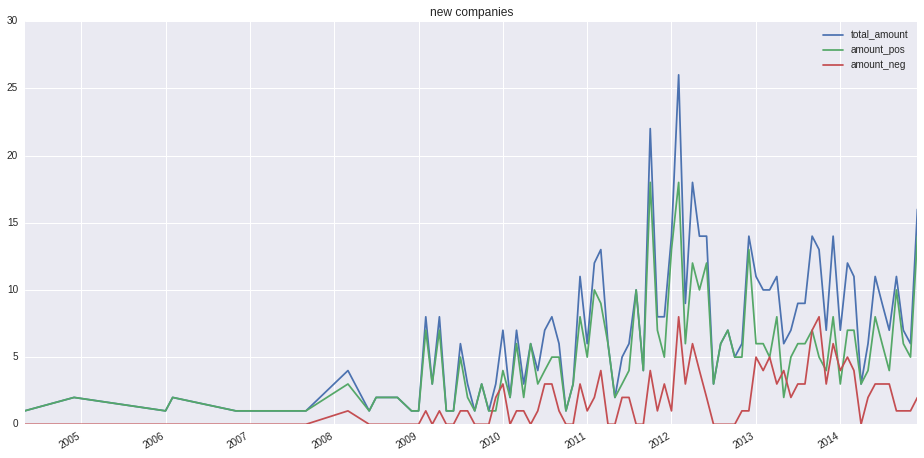

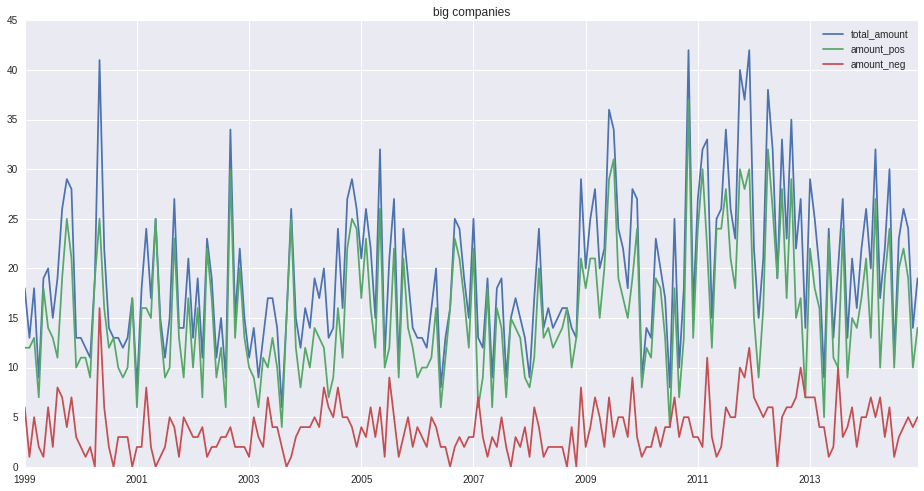

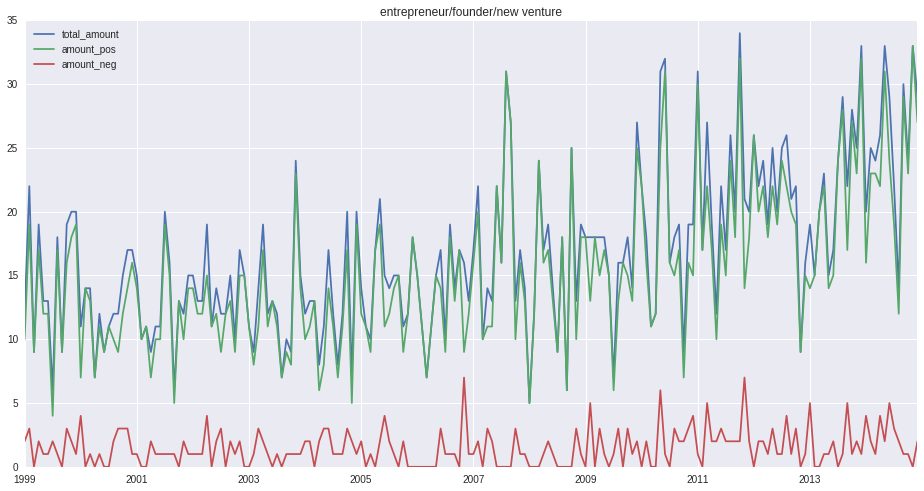

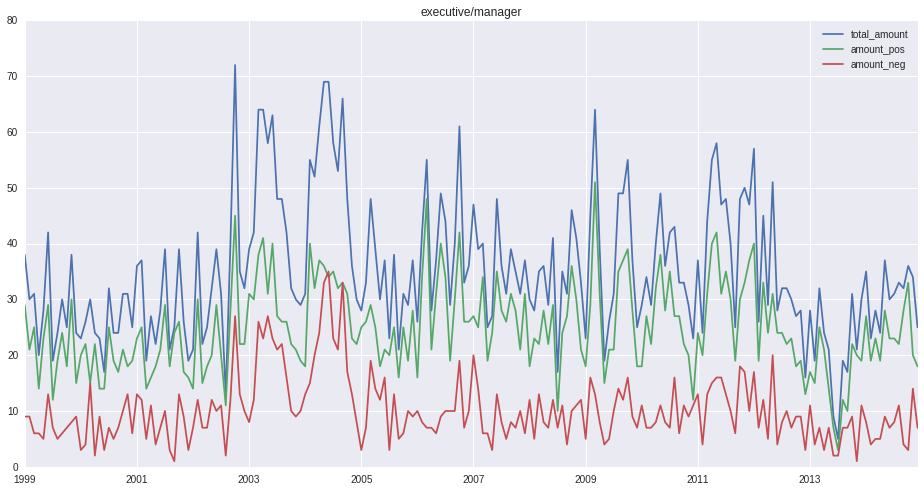

In [120]:
plot(category_list=[3,2, 12,11], info='total', same=False)

## Fig.2 Positive rate of sentences by category over the period 2003 to 2014

/home/antonio/.virtualenvs/nytimes/lib/python3.4/site-packages/ipykernel/__main__.py:58: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


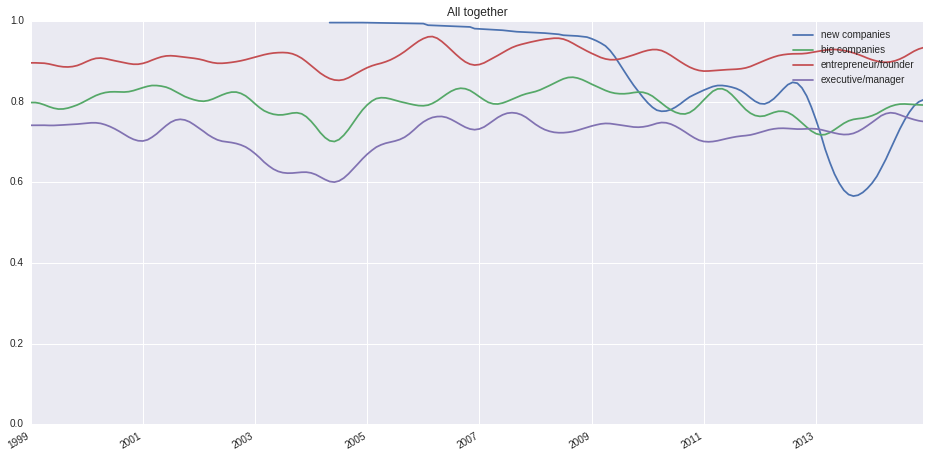

In [121]:
plot(category_list=[3,2, 12,11], info='pos_rate', same=True)